## Convert the images to arrays

And serialize them as bcolz

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *

import os
import glob
import random

import numpy as np

from skimage.transform import resize
from tensorflow.keras.preprocessing import image as image_utils

/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
train_path = "data/train/images/"
train_masks_path = "data/train/masks/"
test_path = "data/test/images"

In [4]:
train_files = glob.glob(os.path.join(train_path, "*.png"))
masks_files = glob.glob(os.path.join(train_masks_path, "*.png"))
test_files = glob.glob(os.path.join(test_path, "*.png"))

In [5]:
assert len(train_files) == len(masks_files)

In [9]:
train_ids = []
x_train = np.zeros((len(train_files), IM_HEIGHT, IM_WIDTH, IM_CHAN), dtype=np.uint8)
y_train = np.zeros((len(masks_files), IM_HEIGHT, IM_WIDTH, 1), dtype=np.bool)

In [10]:
x_train.shape, y_train.shape

((4000, 128, 128, 1), (4000, 128, 128, 1))

In [12]:
for i, (train_path, mask_path) in enumerate(zip(train_files, masks_files)):
    train_id = os.path.basename(train_path)
    mask_id = os.path.basename(mask_path)
    assert train_id == mask_id
    train_ids.append(train_id)
    
    x = image_utils.img_to_array(image_utils.load_img(train_path))
    x = resize(x, (IM_WIDTH, IM_HEIGHT, IM_CHAN), mode='constant', preserve_range=True)
    x_train[i] = x

    y = image_utils.img_to_array(image_utils.load_img(mask_path))
    y = resize(y, (IM_WIDTH, IM_HEIGHT, IM_CHAN), mode='constant', preserve_range=True)
    y_train[i] = y

/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


## Sanity check

In [13]:
n = random.randint(1, x_train.shape[0])

In [14]:
train_ids[n]

'cdc7d77e77.png'

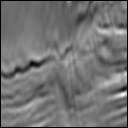

In [15]:
image_utils.array_to_img(x_train[n])

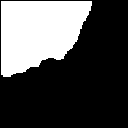

In [16]:
image_utils.array_to_img(y_train[n])

## Test data

In [18]:
test_ids = []
x_test = np.zeros((len(test_files), IM_HEIGHT, IM_WIDTH, IM_CHAN), dtype=np.uint8)

for i, test_path in enumerate(test_files):
    test_id = os.path.basename(test_path)
    test_ids.append(test_id)
    
    x = image_utils.img_to_array(image_utils.load_img(test_path))
    x = resize(x, (IM_WIDTH, IM_HEIGHT, IM_CHAN), mode='constant', preserve_range=True)
    x_test[i] = x

/home/ubuntu/.local/share/virtualenvs/kaggle-salt-WGcE8zWi/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [19]:
x_test.shape

(18000, 128, 128, 1)

In [20]:
n = random.randint(1, x_test.shape[0])

In [21]:
test_ids[n]

'728b06f90b.png'

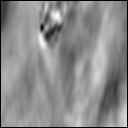

In [22]:
image_utils.array_to_img(x_test[n])

## Save arrays

In [26]:
save_arr("data/train_ids.arr", train_ids)

In [27]:
save_arr("data/x_train.arr", x_train)

In [28]:
save_arr("data/y_train.arr", y_train)

In [29]:
save_arr("data/test_ids.arr", test_ids)

In [30]:
save_arr("data/x_test.arr", x_test)